In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, BatchNormalization, ReLU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2  # Import L2 regularizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import os
import numpy as np
import random

# Function to preprocess spectrograms
def preprocess_spectrogram(spectrogram, target_size):
    # Normalize
    spectrogram = spectrogram / np.max(spectrogram)
    # Resize to match MobileNet input
    spectrogram = tf.image.resize(spectrogram, target_size)
    # Convert to 3 channels (stack the same data for all channels)
    spectrogram = tf.image.grayscale_to_rgb(spectrogram)
    return spectrogram.numpy()

# Data augmentation for spectrograms
def augment_spectrogram(spectrogram):
    # Time shifting
    shift = random.randint(-10, 10)
    spectrogram = np.roll(spectrogram, shift, axis=1)

    # Frequency masking
    freq_mask = random.randint(0, 10)
    spectrogram[:, freq_mask:freq_mask + 10, :] = 0

    # Time masking
    time_mask = random.randint(0, 10)
    spectrogram[time_mask:time_mask + 10, :, :] = 0

    return spectrogram

# Create a model with MobileNetV2 as the base and L2 regularization
def create_model(input_shape):
    # Load MobileNetV2 without the top layers
    weights_path = './models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5'
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tune MobileNetV2
    base_model.trainable = True
    for layer in base_model.layers[:100]:  # Freeze the first 100 layers
        layer.trainable = False

    # Add custom layers with L2 regularization
    model = Sequential([
        base_model,
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),  # L2 regularization
        BatchNormalization(),
        ReLU(),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
        Dropout(0.5),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # L2 regularization
    ])
    return model
# Load and preprocess spectrogram dataset
def load_data(image_folder, txt_folder, target_size):
    image_paths = []
    labels = []

    # Read labels and corresponding spectrogram paths
    for txt_file in os.listdir(txt_folder):
        if txt_file.endswith('.txt'):
            with open(os.path.join(txt_folder, txt_file), 'r') as file:
                label = int(file.read().strip())
                image_name = os.path.splitext(txt_file)[0] + '.jpg'  # Assuming spectrograms are in .jpg format
                image_path = os.path.join(image_folder, image_name)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
                    labels.append(label)

    # Preprocess spectrograms
    X = []
    y = []
    for img_path, label in zip(image_paths, labels):
        spectrogram = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale')
        spectrogram = tf.keras.preprocessing.image.img_to_array(spectrogram)
        spectrogram = preprocess_spectrogram(spectrogram, target_size)
        spectrogram = augment_spectrogram(spectrogram)  # Apply augmentation
        X.append(spectrogram)
        y.append(label)

    return np.array(X), np.array(y)


# Input shape for spectrograms
input_shape = (128, 128, 3)

# Create the model
model = create_model(input_shape)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Display model summary
model.summary()



# Paths to dataset
image_folder = 'Dataset_Model/Final_dataset/56k_train_images'  
txt_folder = 'Dataset_Model/Final_dataset/56k_train_labels'  

# Load data
X, y = load_data(image_folder, txt_folder, (128, 128))

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train, X_val, y_train, y_val)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 4, 4, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,995,585 (15.24 MB)

 Trainable params: 3,598,785 (13.73 MB)

 Non-trainable params: 396,800 (1.51 MB)

[[[[0.7194323  0.7194323  0.7194323 ]
   [0.72161573 0.72161573 0.72161573]
   [0.7478166  0.7478166  0.7478166 ]
   ...
   [0.6943232  0.6943232  0.6943232 ]
   [0.62882096 0.62882096 0.62882096]
   [0.7008734  0.7008734  0.7008734 ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.7281659  0.7281659  0.7281659 ]
   [0.69541484 0.69541484 0.69541484]
   [0.6670306  0.6670306  0.6670306 ]
   ...
   [0.69213974 0.69213974 0.69213974]
   [0.68777287 0.68777287 0.68777287]
   [0.6484716  0.6484716  0.6484716 ]]

  [[0.73908293 0.73908293 0.73908293]
   [0.6

In [2]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Validation labels distribution: {np.bincount(y_val)}")


X_train shape: (44800, 128, 128, 3)
X_val shape: (11200, 128, 128, 3)
y_train shape: (44800,)
y_val shape: (11200,)
Training labels distribution: [ 6400 38400]
Validation labels distribution: [1600 9600]


Epoch 1/100


/opt/homebrew/Cellar/jupyterlab/4.3.1/libexec/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


700/700 ━━━━━━━━━━━━━━━━━━━━ 214s 301ms/step - accuracy: 0.8429 - loss: 5.0708 - precision: 0.8677 - recall: 0.9636 - val_accuracy: 0.8590 - val_loss: 4.6901 - val_precision: 0.8589 - val_recall: 0.9998 - learning_rate: 1.0000e-05
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 239s 341ms/step - accuracy: 0.8797 - loss: 4.5036 - precision: 0.8936 - recall: 0.9751 - val_accuracy: 0.8712 - val_loss: 4.2364 - val_precision: 0.8695 - val_recall: 0.9998 - learning_rate: 1.0000e-05
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 238s 341ms/step - accuracy: 0.8986 - loss: 4.0128 - precision: 0.9117 - recall: 0.9761 - val_accuracy: 0.8859 - val_loss: 3.7302 - val_precision: 0.8838 - val_recall: 0.9981 - learning_rate: 1.0000e-05
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 246s 351ms/step - accuracy: 0.9087 - loss: 3.5574 - precision: 0.9210 - recall: 0.9773 - val_accuracy: 0.8971 - val_loss: 3.2830 - val_precision: 0.8967 - val_recall: 0.9946 - learning_rate: 1.0000e-05
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━

<Figure size 800x600 with 0 Axes>

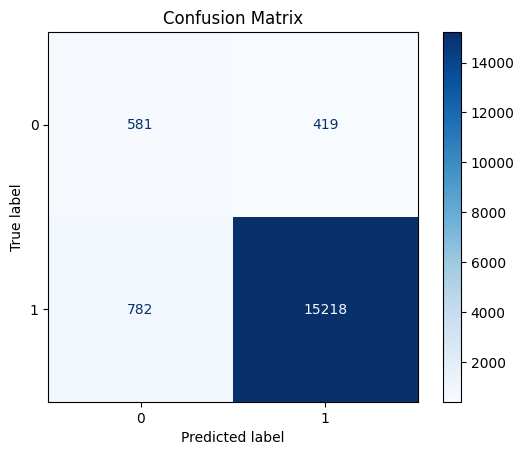

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create data generators
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val, batch_size=64)

# Callbacks for training
callbacks = [
    ModelCheckpoint('best_model_mobilenetv1_l2_Nov22.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks
)

# Save the trained model
model.save('final_model_mobilenetv2_l2_Nov22.keras')

# Load test data
test_image_folder = 'Dataset_Model/Final_dataset/17k_test_images'  # Replace with your test spectrogram images path
test_txt_folder = 'Dataset_Model/Final_dataset/17k_test_labels'  # Replace with your test labels path
X_test, y_test = load_data(test_image_folder, test_txt_folder, (128, 128))

# Evaluate the model on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()


Loading model from: best_model_mobilenetv1_l2_Nov22.keras

Evaluating for folder: SINR_100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
Accuracy: 0.5520
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

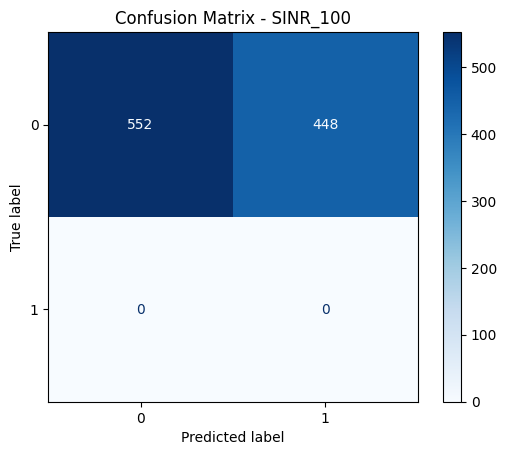


Evaluating for folder: SINR_23
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Accuracy: 0.9970
Precision: 1.0000
Recall: 0.9970
F1 Score: 0.9985
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

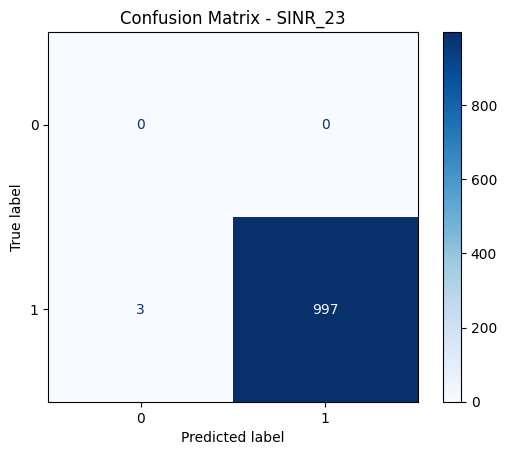


Evaluating for folder: SINR_24
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
Accuracy: 0.9920
Precision: 1.0000
Recall: 0.9920
F1 Score: 0.9960
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

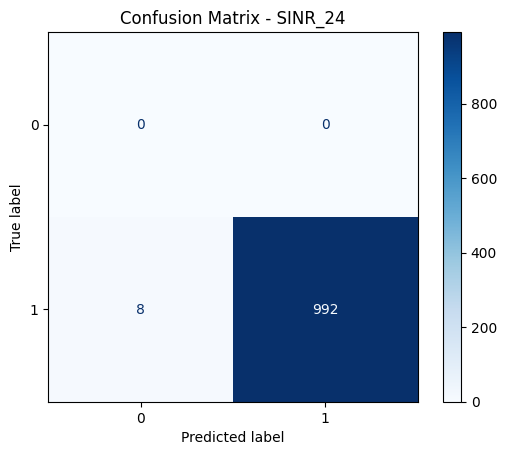


Evaluating for folder: SINR_12
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Accuracy: 0.8460
Precision: 1.0000
Recall: 0.8460
F1 Score: 0.9166
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

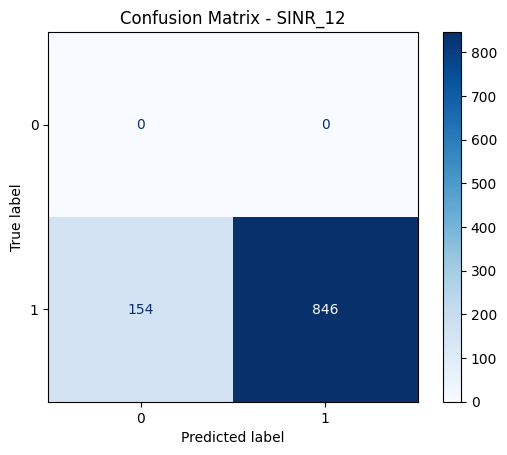


Evaluating for folder: SINR_15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Accuracy: 0.8970
Precision: 1.0000
Recall: 0.8970
F1 Score: 0.9457
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

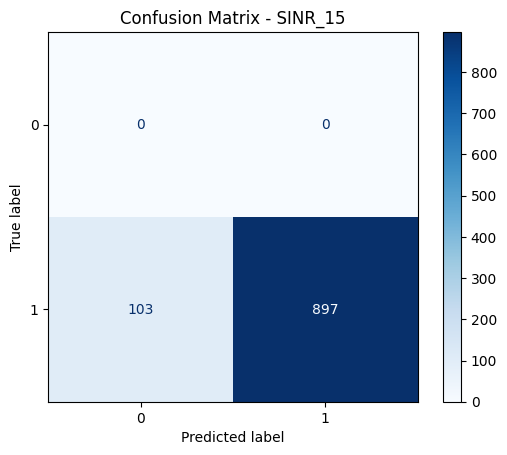


Evaluating for folder: SINR_14
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
Accuracy: 0.8920
Precision: 1.0000
Recall: 0.8920
F1 Score: 0.9429
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

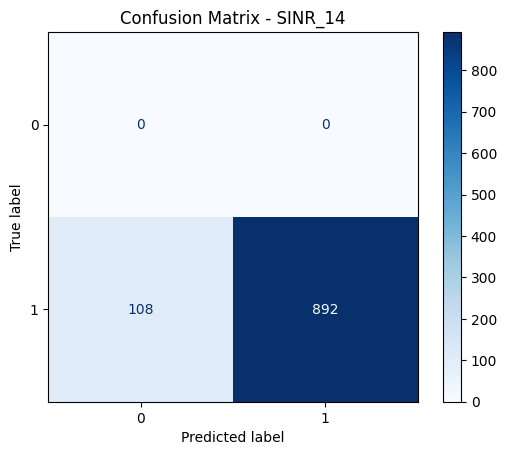


Evaluating for folder: SINR_13
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
Accuracy: 0.8600
Precision: 1.0000
Recall: 0.8600
F1 Score: 0.9247
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

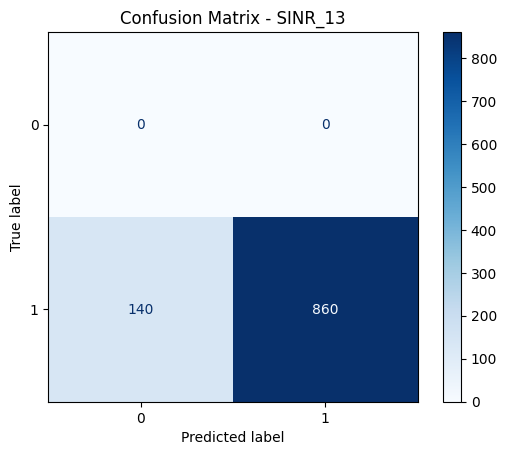


Evaluating for folder: SINR_25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Accuracy: 0.9970
Precision: 1.0000
Recall: 0.9970
F1 Score: 0.9985
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

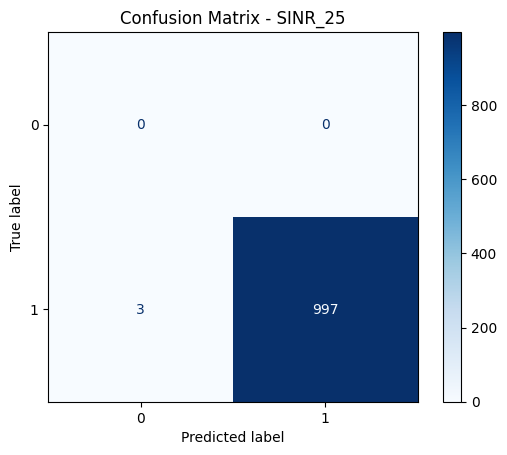


Evaluating for folder: SINR_22
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Accuracy: 0.9980
Precision: 1.0000
Recall: 0.9980
F1 Score: 0.9990
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

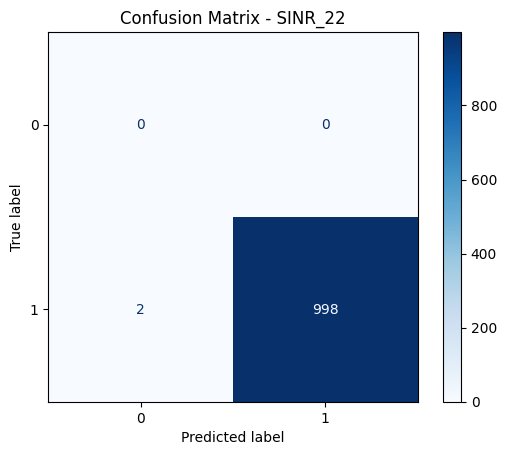


Evaluating for folder: SINR_18
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
Accuracy: 0.9590
Precision: 1.0000
Recall: 0.9590
F1 Score: 0.9791
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

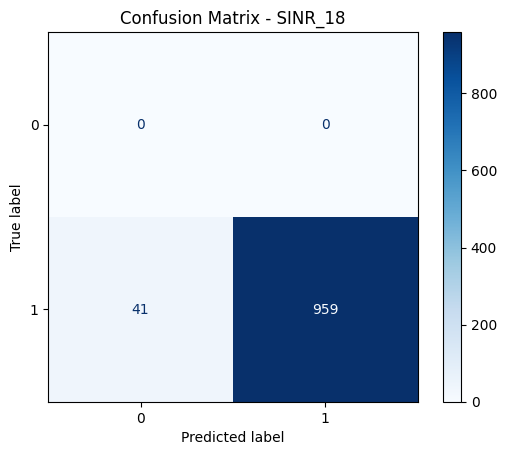


Evaluating for folder: SINR_20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Accuracy: 0.9750
Precision: 1.0000
Recall: 0.9750
F1 Score: 0.9873
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

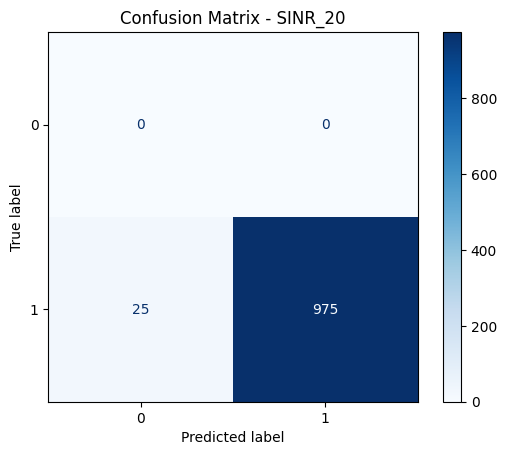


Evaluating for folder: SINR_16
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Accuracy: 0.9230
Precision: 1.0000
Recall: 0.9230
F1 Score: 0.9600
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

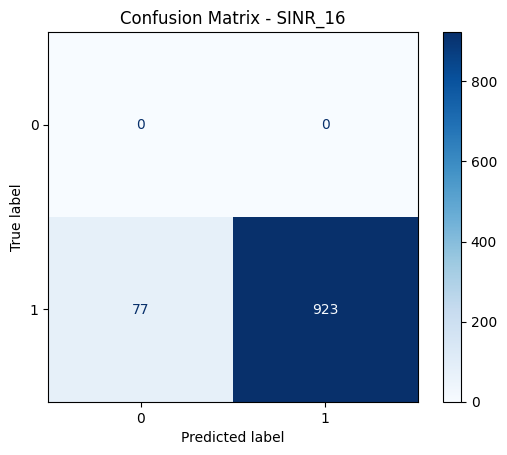


Evaluating for folder: SINR_11
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Accuracy: 0.8150
Precision: 1.0000
Recall: 0.8150
F1 Score: 0.8981
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

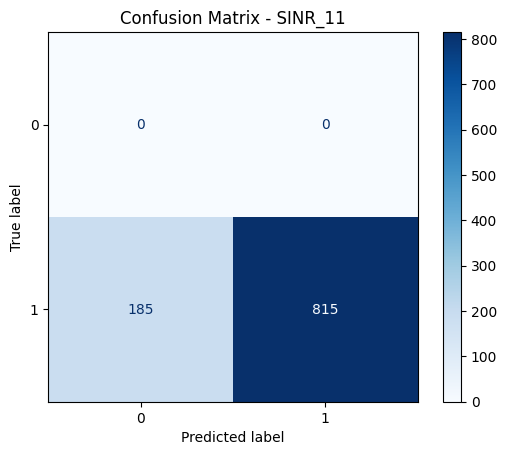


Evaluating for folder: SINR_10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
Accuracy: 0.7930
Precision: 1.0000
Recall: 0.7930
F1 Score: 0.8846
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

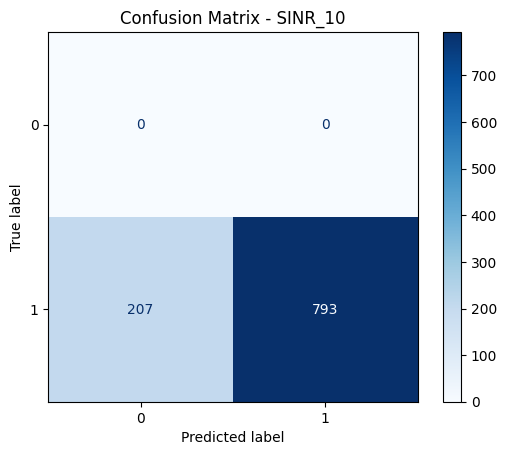


Evaluating for folder: SINR_17
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Accuracy: 0.9440
Precision: 1.0000
Recall: 0.9440
F1 Score: 0.9712
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

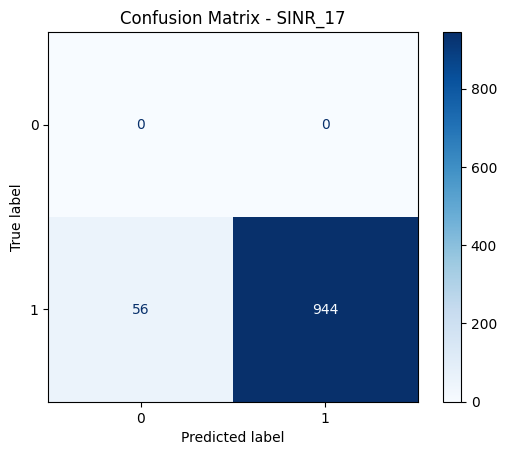


Evaluating for folder: SINR_21
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Accuracy: 0.9850
Precision: 1.0000
Recall: 0.9850
F1 Score: 0.9924
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

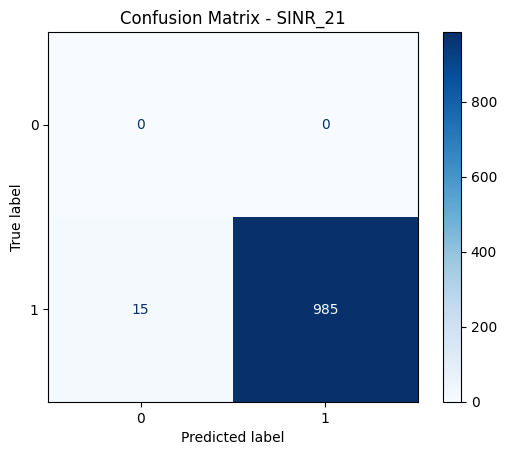


Evaluating for folder: SINR_19
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Accuracy: 0.9570
Precision: 1.0000
Recall: 0.9570
F1 Score: 0.9780
ROC AUC Score: N/A (Only one class in labels)


<Figure size 800x600 with 0 Axes>

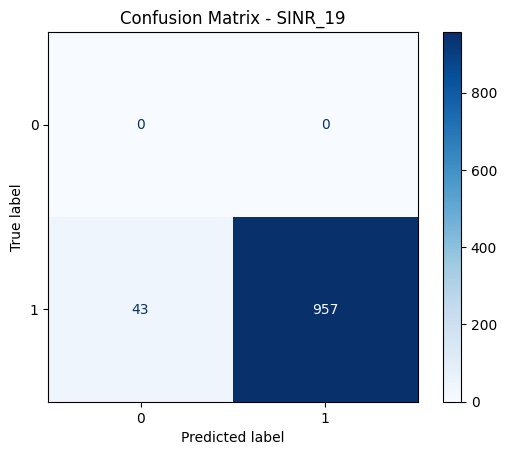

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import cv2

# Function to preprocess a single image
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or invalid format: {image_path}")
    image = cv2.resize(image, target_size)
    image = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB
    return image / 255.0  # Normalize

# Function to load test data from a folder
def load_test_data(image_folder, label_folder, target_size):
    image_paths = []
    labels = []

    for txt_file in os.listdir(label_folder):
        if txt_file.endswith('.txt'):
            with open(os.path.join(label_folder, txt_file), 'r') as file:
                label = int(file.read().strip())
                image_name = os.path.splitext(txt_file)[0] + '.jpg'  # Assuming images are in .jpg format
                image_path = os.path.join(image_folder, image_name)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
                    labels.append(label)
                #else:
                    #print(f"Warning: No matching image for label {txt_file}")

    X = [preprocess_image(img_path, target_size) for img_path in image_paths]
    return np.array(X), np.array(labels)

# Function to evaluate a model on a dataset
def evaluate_model(model, X, y, folder_name):
    print(f"\nEvaluating for folder: {folder_name}")
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)

    # Handle ROC AUC calculation
    if len(np.unique(y)) > 1:  # Check if both classes are present
        roc_auc = roc_auc_score(y, y_pred_prob)
    else:
        roc_auc = "N/A (Only one class in labels)"

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc}")

    # Generate and display confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(f"Confusion Matrix - {folder_name}")
    plt.show()

# Main script
if __name__ == "__main__":
    # Paths
    master_image_folder = "Dataset_Model/Final_dataset/TEST/TEST_images" 
    master_label_folder = "Dataset_Model/Final_dataset/TEST/TEST_labels"  
    model_path = "best_model_mobilenetv1_l2_Nov22.keras"  
    target_size = (128, 128)  

    # Load the model
    print(f"Loading model from: {model_path}")
    model = load_model(model_path)

    # Iterate through folders in the master folder
    for folder_name in os.listdir(master_image_folder):
        image_folder = os.path.join(master_image_folder, folder_name)
        label_folder = os.path.join(master_label_folder, folder_name)

        # Check if both image and label folders exist
        if os.path.isdir(image_folder) and os.path.isdir(label_folder):
            # Load data
            X_test, y_test = load_test_data(image_folder, label_folder, target_size)

            # Ensure data is not empty
            if len(X_test) > 0 and len(y_test) > 0:
                # Evaluate the model for the current folder
                evaluate_model(model, X_test, y_test, folder_name)
            else:
                print(f"Warning: No valid data found in folder {folder_name}")
